**I. PREPARE DATA**

In [ ]:
!pip install quandl

In [ ]:
!pip install PyPortfolioOpt

!pip install plotly

In [ ]:
from pypfopt.discrete_allocation import DiscreteAllocation, get_latest_prices
from pypfopt import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns
from pypfopt import plotting
import copy
import numpy as np
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
import numpy as np
from numpy import sqrt
import pandas as pd
import datetime
from datetime import datetime

# Libraries to help with data visualization
import matplotlib.pyplot as plt
import seaborn as sns
sns.color_palette("Paired")

#library optimal
import quandl
import scipy.optimize as sco

# Removes the limit for the number of displayed columns
pd.set_option("display.max_columns", None)

# Sets the limit for the number of displayed rows
pd.set_option("display.max_rows", 200)

# to scale the data using z-score
from sklearn.preprocessing import StandardScaler

# to compute distances
from scipy.spatial.distance import pdist, cdist

# to perform k-means clustering, compute metric
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

#!pip install yellowbrick
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

# to perform PCA
from sklearn.decomposition import PCA

#ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [ ]:
from google.colab import files
upload = files.upload()

In [ ]:
from google.colab import files
upload = files.upload()

In [ ]:
from google.colab import files
upload = files.upload()

Saving data_thanh (2).xlsx to data_thanh (2).xlsx


In [ ]:
from google.colab import files
upload = files.upload()

Saving data_thanh (1).xlsx to data_thanh (1).xlsx


In [ ]:
hose = pd.read_csv('VN Index Historical Data.csv')
hose = hose.iloc[:,:2]
hose.head()

,Date,Price
0,12/30/2022,"1,007.09"
1,12/29/2022,"1,009.29"
2,12/28/2022,"1,015.66"
3,12/27/2022,"1,004.57"
4,12/26/2022,985.21


In [ ]:
#read data
roe = pd.read_excel('data_thanh (1).xlsx', sheet_name ='roe' )
ta = pd.read_excel('data_thanh (1).xlsx', sheet_name ='total assets')
debt = pd.read_excel('data_thanh (1).xlsx', sheet_name ='total debt')
pb = pd.read_excel('data_thanh (1).xlsx', sheet_name ='PB')
equity = pd.read_excel('data_thanh_3 (1).xlsx', sheet_name ='Equity')
ni = pd.read_excel('data_thanh (2).xlsx', sheet_name ='net income')
cap = pd.read_excel('data_thanh (2).xlsx', sheet_name ='Market Cap')

In [ ]:
indus = pd.read_excel('data_thanh (2).xlsx', sheet_name ='code')

In [ ]:
hnx = pd.read_excel('data_thanh (1).xlsx', sheet_name ='HNX index')
hnx = hnx.iloc[:,[0,-1]]

In [ ]:
#clean data
def add(df):
  df = df.iloc[:,1:]
  df.columns = ['Stock','Code','amount']
  df=df.iloc[1:,:]
  df['Code'] = pd.to_datetime(df['Code'])
  df['Code'] = df['Code'].dt.strftime("%Y")
  df.dropna(axis=0, subset='Code', inplace = True)
  df['Code'] = df.Code.astype('int')
  df = df[df['Code'].isin([2021,2018,2019,2017,2020])]
  return df
#apply def
equity = add(equity)
ni = add(ni)
cap = add(cap)

In [ ]:
#clean data
def aggr(df):
  df = df.rename(columns=df.iloc[0])
  df =  df.iloc[2:,:]
  df = pd.melt(df, id_vars='Code', value_vars = list(df.columns[1:]), var_name='Stock', value_name='amount')
  df['Code'] = df.Code.astype('int')
  df = df[df['Code'].isin([2021,2018,2019,2017,2020])]
  return df

# apply def
roe = aggr(roe)
ta = aggr(ta)
debt = aggr(debt)
pb = aggr(pb)

In [ ]:
#@title
# clean indus dataframe
indus = indus.iloc[:,:4]
indus.rename({'Updated at 14:23:40':'Stock', 'Company Common Name': 'Name','GICS Industry Name':'Industry'},axis = 1,inplace=True)
indus.head()

In [ ]:
# def split ticker
def stock(ticker):
    s = ticker.split('.')
    return s[0]

#split dataframe
def split_df(df):
  df.dropna(axis=0, subset=list(df.columns), inplace = True)
  df['Stock'] = df.Stock.apply(stock)
  return df

# #apply def
roe = split_df(roe)
ta = split_df(ta)
debt = split_df(debt)
pb = split_df(pb)
indus = split_df(indus)
equity = split_df(equity)
cap = split_df(cap)
ni = split_df(ni)

In [ ]:
# convert type
def tp(df):
  df['amount'] = df['amount'].astype('float')
  df['Code'] = df['Code'].astype('float')
  return df

#apply def
roe = tp(roe)
ta = tp(ta)
debt = tp(debt)
pb = tp(pb)
equity = tp(equity)
cap = tp(cap)
ni = tp(ni)

In [ ]:
# merge data
result = pd.merge(roe, ta, on=["Code", "Stock"], how = 'outer', suffixes=('_roe', '_size'))
result = pd.merge(result, pb, on=["Code", "Stock"], how = 'outer', suffixes=('', '_pb'))
result = pd.merge(result,equity, on=["Code", "Stock"], how = 'outer', suffixes=('', '_equity'))
result = pd.merge(result,debt, on=["Code", "Stock"], how = 'outer', suffixes=('', '_debt'))
result = pd.merge(result, ni, on=["Code", "Stock"], how = 'outer', suffixes=('', '_ni'))
result = pd.merge(result, cap, on=["Code", "Stock"], how = 'outer', suffixes=('', '_cap'))
result.dropna(axis=0, subset=list(result.columns), inplace = True)
result.head()

In [ ]:
# calculate some ratios
result['size'] = np.log(result['amount_size'])
result['roa'] = result['amount_ni']/(result['amount_size']*1000)
result['d/e'] = (result['amount_debt']*1000)/result['amount_equity']
result['p/e'] = result['amount_cap']/result['amount_ni']
result = result.rename({'amount':'p/b'},axis=1)
result.drop(['amount_size','amount_debt','amount_equity','amount_cap','amount_ni'],axis=1,inplace=True)

In [ ]:
data = result.copy()

In [ ]:
data.head(15)

In [ ]:
# clean roe
def clean_roa(x):
   return float(x/100)
for col in  data.loc[:,data.columns.str.startswith('amount_roe')].columns:
    data[col] = data[col].apply(lambda x:clean_roa(x))

In [ ]:
# split data into each year
df_2021 = data[data['Code']==2021]
df_2017 = data[data['Code']==2017]
df_2018 = data[data['Code']==2018]
df_2019 = data[data['Code']==2019]
df_2020 = data[data['Code']==2020]

In [ ]:
#remove duplicate
df_2021=df_2021.drop_duplicates(subset=['Stock'])
df_2020=df_2020.drop_duplicates(subset=['Stock'])
df_2019=df_2019.drop_duplicates(subset=['Stock'])
df_2018=df_2018.drop_duplicates(subset=['Stock'])
df_2017=df_2017.drop_duplicates(subset=['Stock'])

In [ ]:
remove_out(data.drop(['Code'],axis=1).set_index('Stock'))

In [ ]:
remove_out(new_df).describe().round(2)

In [ ]:
# amount of companies of each year
print(df_2021.shape)
print(df_2020.shape)
print(df_2019.shape)
print(df_2018.shape)
print(df_2017.shape)
# print(df_2022.shape)

**II. PRE PROCESSING DATA**

In [ ]:
# #remove oulier
def  remove_out(df):
  exclude_df=df.copy()
  for col in exclude_df.columns:
    mean_col = exclude_df[col].mean()
    std_col = exclude_df[col].std()
    left_bound = mean_col - 3*std_col
    right_bound = mean_col + 3*std_col
    exclude_df = exclude_df[(exclude_df[col]>=left_bound) & (exclude_df[col]<=right_bound)]
  return exclude_df

def remove(exclude_df):
  df_remove = remove_out(exclude_df.drop(['Code'],axis=1).set_index('Stock'))
  df_remove = df_remove.dropna(axis=0, subset=list(df_remove.columns))
  return df_remove

In [ ]:
# remove outlier
df_re_2021 = remove(df_2021)
df_re_2020 = remove(df_2020)
df_re_2019 = remove(df_2019)
df_re_2018 = remove(df_2018)
df_re_2017 = remove(df_2017)

In [ ]:
#normalize data
from sklearn.preprocessing import MinMaxScaler
def scale(df):
  minmax = MinMaxScaler()
  v_scaled = minmax.fit_transform(df)
  subset_scaled_df = pd.DataFrame(v_scaled, columns = df.columns)
  return subset_scaled_df

In [ ]:
subset_scaled_df_2021 = scale(df_re_2021)
subset_scaled_df_2020 = scale(df_re_2020)
subset_scaled_df_2019 = scale(df_re_2019)
subset_scaled_df_2018 = scale(df_re_2018)
subset_scaled_df_2017 = scale(df_re_2017)

In [ ]:
df_2020

**III. CLUSTER**

In [ ]:

def dis(subset_scaled_df):
  clusters=range(1,10)
  meanDistortions=[]

  for k in clusters:
      model=KMeans(n_clusters=k, random_state=0)
      model.fit(subset_scaled_df)
      prediction=model.predict(subset_scaled_df)
      distortion=sum(np.min(cdist(subset_scaled_df, model.cluster_centers_, 'euclidean'), axis=1)) / subset_scaled_df.shape[0]
      meanDistortions.append(distortion)

      print('Number of Clusters:', k, '\tAverage Distortion:', distortion)
  sns.set_style("white")
  plt.plot(clusters, meanDistortions, 'bx-')
  plt.xlabel('k')
  plt.ylabel('Average Distortion')
  plt.title('Selecting k with the Elbow Method', fontsize=15)
  return 'Number of Clusters:', k, '\tAverage Distortion:', distortion; plt.show()

In [ ]:
def sihou(subset_scaled_df):
  sil_score = []
  cluster_list = list(range(2,10))
  for n_clusters in cluster_list:
      clusterer = KMeans(n_clusters=n_clusters, random_state=0)
      preds = clusterer.fit_predict((subset_scaled_df))
      centers = clusterer.cluster_centers_
      score = silhouette_score(subset_scaled_df, preds)
      sil_score.append(score)
      print("For n_clusters = {}, silhouette score is {})".format(n_clusters, score))
  sns.set_style("white")
  plt.plot(cluster_list,sil_score)
  plt.xlabel('Number of cluster (k)')
  plt.ylabel('Average Silhou width')
  plt.title('Selecting k with the Silhouette', fontsize=15)
  return plt.show()

In [ ]:
# Finding optimal no. of clusters with silhouette coefficients
def viz(df,n):
  visualizer = SilhouetteVisualizer(KMeans(n, random_state = 1))
  visualizer.fit(df)
  sns.set_style("white")
  sns.color_palette("tab10")
  return visualizer.show()

In [ ]:
  #pca
def pca_plot(df,df_re,n):
    pca = PCA(n_components=2)
    X_reduced_pca = pca.fit_transform(df)
    reduced_df_pca = pd.DataFrame(data=X_reduced_pca, columns=["Component 1", "Component 2"])
    kmeans = KMeans(n_clusters=n, random_state=1)
    kmeans.fit(df)
    df['K_means_segments'] = kmeans.labels_
    df_re['K_means_segments'] = kmeans.labels_
    sns.set_style("white")
    sns.scatterplot(
        data=reduced_df_pca,
        x="Component 1",
        y="Component 2",
        hue=df["K_means_segments"],palette='tab10')
    plt.legend(bbox_to_anchor=(1, 1))
    return plt.show()

**YEAR 2017**

In [ ]:
pca_plot(subset_scaled_df_2018,df_re_2018,3)

In [ ]:
sihou(subset_scaled_df_2017)

In [ ]:
viz(subset_scaled_df_2017,3)

In [ ]:
pca_plot(subset_scaled_df_2017,df_re_2017,3)

**Year 2018**

In [ ]:
dis(subset_scaled_df_2018)

In [ ]:
sihou(subset_scaled_df_2018)

In [ ]:
viz(subset_scaled_df_2018,3)

In [ ]:
pca_plot(subset_scaled_df_2018, df_re_2018, 3)

**YEAR 2019**

In [ ]:
dis(subset_scaled_df_2019)

In [ ]:
sihou(subset_scaled_df_2019)

In [ ]:
viz(subset_scaled_df_2019,3)

In [ ]:
pca_plot(subset_scaled_df_2019, df_re_2019, 3)

In [ ]:
dis(subset_scaled_df_2020)

In [ ]:
sihou(subset_scaled_df_2020)

In [ ]:
viz(subset_scaled_df_2020,4)

In [ ]:
pca_plot(subset_scaled_df_2020, df_re_2020, 4)

**YEAR 2021**

In [ ]:
dis(subset_scaled_df_2021)

In [ ]:
sihou(subset_scaled_df_2021)

In [ ]:
viz(subset_scaled_df_2021,4)

In [ ]:
pca_plot(subset_scaled_df_2021, df_re_2021, 4)

**IV. EDA CLUSTER**

In [ ]:
def eda(subset_scaled_df, df_re):
  cluster_profile = df_re.groupby('K_means_segments').mean().round(2)
  cluster_profile['count_in_each_segments'] = df_re.reset_index().groupby('K_means_segments')['Stock'].count().values
  fig, axes = plt.subplots(2, 3,  figsize=(10, 8))
  fig.suptitle('Boxplot of numerical variables for each cluster', fontsize=20)
  counter = 0
  for ii in range(2):
      for jj in range(3):
          if counter <11:
              sns.boxplot(ax=axes[ii, jj],y=subset_scaled_df[df_re.columns[counter]],x=subset_scaled_df['K_means_segments'])
          counter = counter+1

  return cluster_profile


In [ ]:
eda(subset_scaled_df_2018,df_re_2018)

In [ ]:
# let's see the names of the securities in each cluster
def cluser (df_re):
  for cl in df_re["K_means_segments"].unique():
    print(
        "The",
        df_re[df_re["K_means_segments"] == cl].index.nunique(),
        "Securities in cluster",
        cl,
        "are:",
    )
    print(list(df_re[df_re["K_means_segments"] == cl].index.unique()))
    print("-" * 100, "\n")

In [ ]:
cluser(df_re_2017)

In [ ]:
cluser(df_re_2018)

In [ ]:
cluser(df_re_2019)

In [ ]:
cluser(df_re_2020)

In [ ]:
cluser(df_re_2021)

In [ ]:
eda(subset_scaled_df_2017, df_re_2017)

In [ ]:
eda(subset_scaled_df_2018, df_re_2018)

In [ ]:
eda(subset_scaled_df_2019, df_re_2019)

In [ ]:
eda(subset_scaled_df_2020, df_re_2020)

In [ ]:
eda(subset_scaled_df_2021, df_re_2021)

**V. OPTIMAL PORFOLIO**

In [ ]:
def add(df):
  df.columns = ['Date','HNX']
  df['Date'] = pd.to_datetime(df['Date'])
  # df['Date'] = df['Date'].dt.strftime("%Y-%M-%D")
  df.fillna(method='ffill')
  return df

In [ ]:
def add_index(df):
  df.columns = ['Date','VNINDEX']
  df['Date'] = pd.to_datetime(df['Date'])
  # df['Date'] = df['Date'].dt.strftime("%Y-%M-%D")
  df.fillna(method='ffill')
  return df
def spli(x):
  x = x.replace(',','')
  return x
def hose_time(df):
  df = df.groupby(df.index.strftime('%Y-%m')).first()
  return df

In [ ]:
hnx = add(hnx)
hose = add_index(hose)
hose['VNINDEX']=hose['VNINDEX'].apply(spli).astype('float')
hose.head()

,Date,VNINDEX
0,2022-12-30,1007.09
1,2022-12-29,1009.29
2,2022-12-28,1015.66
3,2022-12-27,1004.57
4,2022-12-26,985.21


In [ ]:
price= pd.read_excel('data_thanh (1).xlsx', sheet_name ='close price' )
code = price.iloc[3]
b=[]

# clean price
def change_delist_code(s):
  b = s.split('.')
  return b[0]
code_labels = list(code.apply(change_delist_code))
price.columns = code_labels
price = price.iloc[5:,:]

# split price by year
price_2022 = price.loc[(price['Code'] > datetime.strptime('2021-12-01', '%Y-%m-%d'))].set_index('Code').sort_index()
price_2021 = price.loc[(price['Code'] > datetime.strptime('2020-11-30', '%Y-%m-%d')) &(price['Code'] < datetime.strptime('2022-01-01', '%Y-%m-%d'))].set_index('Code').sort_index()
price_2020 = price.loc[(price['Code'] > datetime.strptime('2019-11-30', '%Y-%m-%d')) &(price['Code'] < datetime.strptime('2021-01-01', '%Y-%m-%d'))].set_index('Code').sort_index()
price_2019 = price.loc[(price['Code'] > datetime.strptime('2018-11-30', '%Y-%m-%d')) &(price['Code'] < datetime.strptime('2020-01-01', '%Y-%m-%d'))].set_index('Code').sort_index()
price_2018 = price.loc[(price['Code'] > datetime.strptime('2017-11-30', '%Y-%m-%d')) &(price['Code'] < datetime.strptime('2019-01-01', '%Y-%m-%d'))].set_index('Code').sort_index()
price_2017 = price.loc[(price['Code'] > datetime.strptime('2016-11-30', '%Y-%m-%d')) &(price['Code'] < datetime.strptime('2018-01-01', '%Y-%m-%d'))].set_index('Code').sort_index()

# find these stocks in 2 df
def find(df,pr):
  dr=[]
  # df= df.drop('Year',axis=1).set_index('Stock')
  st = list(df.index.values)
  price_st=list(pr.columns)
  for i in range(len(price_st)):
    if price_st[i] not in st:
      dr.append(price_st[i])
  return dr

#drop stock not in 1st df
def delti(df,pr):
  pr=pr.drop(find(df,pr), axis=1)
  return pr


Year 2017

In [ ]:
def hose_time(df):
  return df.groupby(df.set_index('Date').index.strftime('%Y-%m')).first().drop('Date',axis = 1)

#hnx exchange
def hnx_time(df):
  df = df.groupby(df.set_index('Date').index.strftime('%Y-%m')).last().drop('Date',axis=1)
  return df
#stock
def stock_time(df):
  df = df.groupby(df.index.strftime('%Y-%m')).last()
  return df

In [ ]:
def ye_(df_re,price_2x,price_1x,subset_scaled_df,as_date, end_date, hose,hnx,n,indus):
  from sklearn.metrics import pairwise_distances_argmin_min
  year_x = delti(df_re,price_2x)
  port_x = delti(df_re,price_1x)
  km = KMeans(n_clusters=n).fit(subset_scaled_df)
  closest, _ = pairwise_distances_argmin_min(km.cluster_centers_, subset_scaled_df)
  col_year= list(closest)
  df_year= df_re.reset_index()
  col = list(df_year[df_year['Stock'].isin(list(df_year.iloc[col_year]['Stock']))]['Stock'])
  stocks =  year_x[col]
  return_ptf_index = stock_time(stocks).loc[as_date:end_date].join(hose_time(hose).loc[as_date:end_date]).join(hnx_time(hnx).loc[as_date:end_date]).pct_change().dropna()+1
#   return return_ptf_index
# def plot_por(return_ptf_index):
  return_ptf_index['port'] = return_ptf_index[col].sum(axis=1)/len(col)
  return_ptf_index['cluster_portfolio_return'] = return_ptf_index['port']
  return_ptf_index['VNINDEX_return'] = return_ptf_index['VNINDEX']
  return_ptf_index['HNX_return'] = return_ptf_index['HNX']
  plt.figure(figsize = (10,6))
  ax = plt.gca()
  plt.title("Portfolio Performance")
  return_ptf_index['cluster_portfolio_return'].cumprod().plot(ax=ax,color=sns.color_palette()[1],linewidth=2)
  return_ptf_index['VNINDEX_return'].cumprod().plot(ax=ax,color=sns.color_palette()[2],linewidth=2)
  return_ptf_index['HNX_return'].cumprod().plot(ax=ax,color=sns.color_palette()[3],linewidth=2)
  plt.xlabel("Date")
  plt.ylabel("Cumulative Return %")
  plt.legend()
  indus.loc[col,]
  return col

['TTB', 'VC2', 'INN']

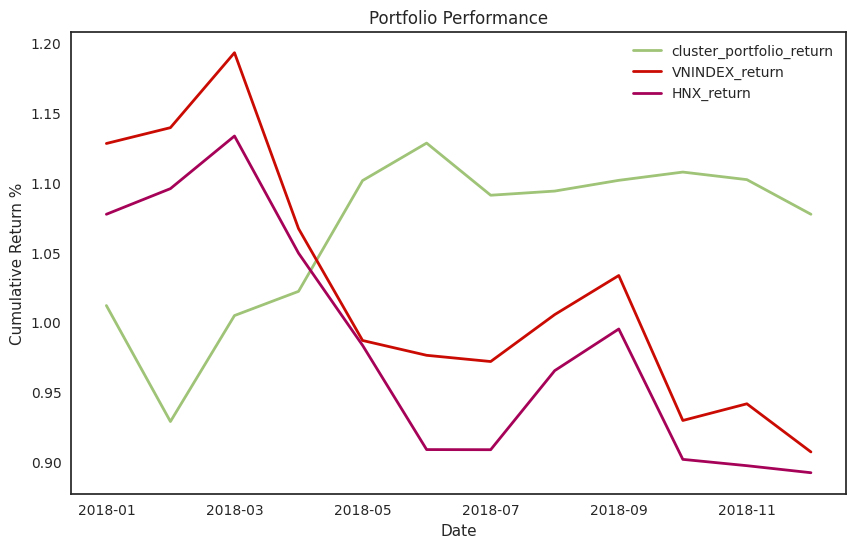

In [ ]:
ye_(df_re_2017,price_2018, price_2017,subset_scaled_df_2017,'2017-12','2018-12',hose,hnx,3,indus)

['PCE', 'VTV', 'VHL']

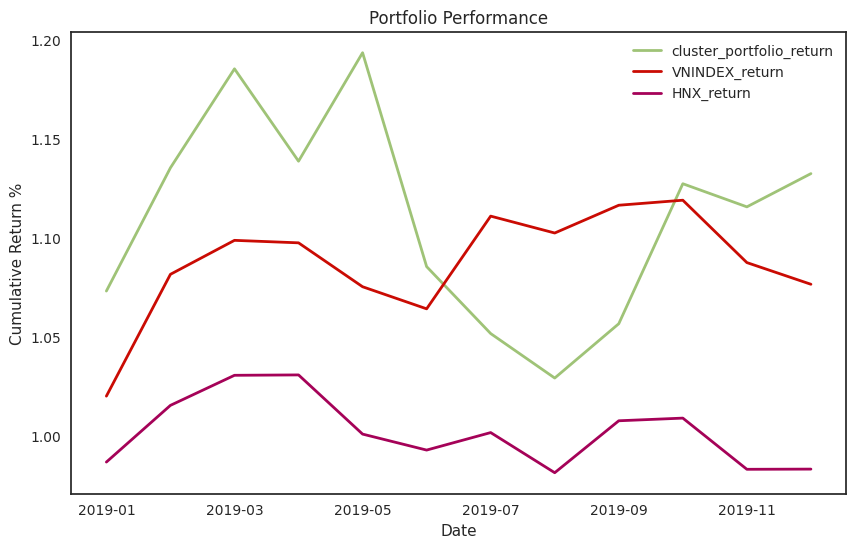

In [ ]:
ye_(df_re_2018,price_2019, price_2018,subset_scaled_df_2018,'2018-12','2019-12',hose,hnx,3, indus)

['TVS', 'TLD', 'SJD']

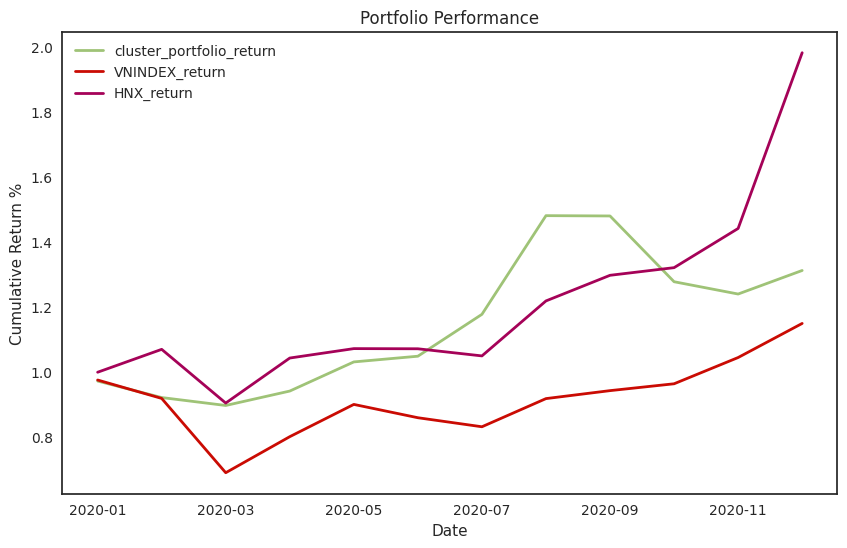

In [ ]:
ye_(df_re_2019,price_2020, price_2019,subset_scaled_df_2019,'2019-12','2020-12',hose,hnx,3, indus)

['NHH', 'UIC', 'VC7', 'PLC']

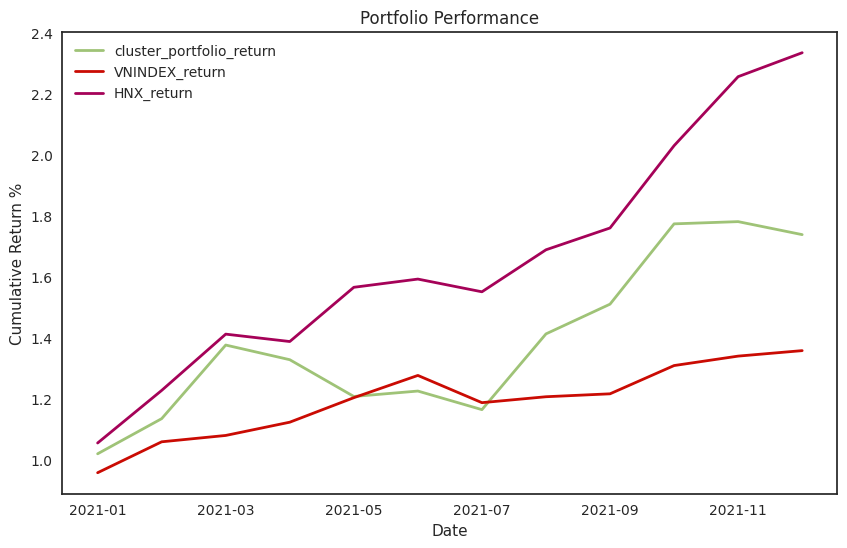

In [ ]:
ye_(df_re_2020,price_2021, price_2020,subset_scaled_df_2020,'2020-12','2021-12',hose,hnx,4,indus)

['TLD', 'SJD', 'CMG', 'SJE']

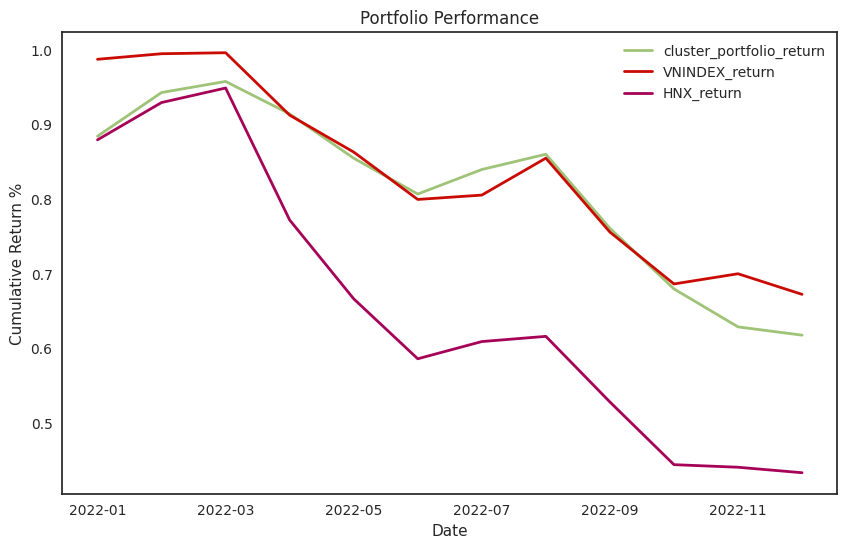

In [ ]:
ye_(df_re_2021,price_2022, price_2021,subset_scaled_df_2021,'2021-12','2022-12',hose,hnx,4,indus)

In [ ]:
def hose_time(df):
  return df.groupby(df.set_index('Date').index.strftime('%Y-%m')).first().drop('Date',axis = 1)

#hnx exchange
def hnx_time(df):
  df = df.groupby(df.set_index('Date').index.strftime('%Y-%m')).last().drop('Date',axis=1)
  return df
#stock
def stock_time(df):
  df = df.groupby(df.index.strftime('%Y-%m')).last()
  return df

In [ ]:
return_por_2017 = price.set_index('Code').loc['2019-01-01':'2019-12-31',['PCE', 'VTV', 'VHL']]
return_por_2017

,PCE,VTV,VHL
Code,,,
2019-12-31,8100,9500,31000
2019-12-30,8800,9500,28500
2019-12-27,8000,9500,28000
2019-12-26,8000,9500,26000
2019-12-25,8000,9500,27000
...,...,...,...
2019-01-07,6400,10500,29000
2019-01-04,6400,10500,29000
2019-01-03,6400,10500,29000


In [ ]:
table=return_por_2017.sort_index()

In [ ]:
returns_daily = table.pct_change()
returns_annual = returns_daily.mean() * 250
selected = ['TTB', 'VC2', 'INN']
# get daily and covariance of returns of the stock
cov_daily = returns_daily.cov()
cov_annual = cov_daily * 250

# empty lists to store returns, volatility and weights of imiginary portfolios
port_returns = []
port_volatility = []
stock_weights = []

# set the number of combinations for imaginary portfolios
num_assets = len(selected)
num_portfolios = 50000

# populate the empty lists with each portfolios returns,risk and weights
for single_portfolio in range(num_portfolios):
    weights = np.random.random(num_assets)
    weights /= np.sum(weights)
    returns = np.dot(weights, returns_annual)
    volatility = np.sqrt(np.dot(weights.T, np.dot(cov_annual, weights)))
    port_returns.append(returns)
    port_volatility.append(volatility)
    stock_weights.append(weights)

# a dictionary for Returns and Risk values of each portfolio
portfolio = {'Returns': port_returns,
             'Volatility': port_volatility}

# extend original dictionary to accomodate each ticker and weight in the portfolio
for counter,symbol in enumerate(selected):
    portfolio[symbol+' weight'] = [weight[counter] for weight in stock_weights]

# make a nice dataframe of the extended dictionary
df = pd.DataFrame(portfolio)

# get better labels for desired arrangement of columns
column_order = ['Returns', 'Volatility'] + [stock+' weight' for stock in selected]

# reorder dataframe columns
df = df[column_order]

df.

,Returns,Volatility,TTB weight,VC2 weight,INN weight
0,0.268531,0.287680,0.476893,0.387084,0.136023
1,0.406824,0.306010,0.618943,0.194358,0.186699
2,0.162722,0.308648,0.383203,0.050738,0.566059
3,0.288987,0.293377,0.496847,0.392707,0.110446
4,-0.090929,0.294918,0.119843,0.495159,0.384997


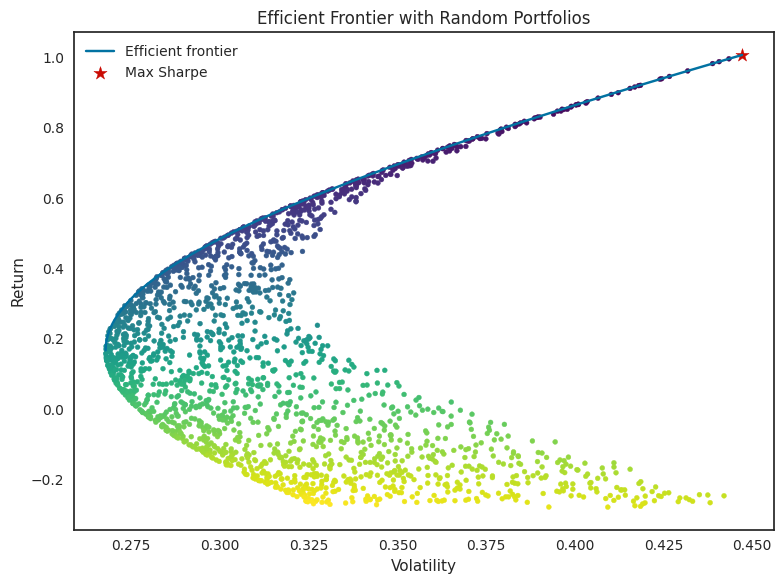

In [ ]:
#@title
def plot_efficient_frontier_and_max_sharpe(mu, S):
    # Optimize portfolio for maximal Sharpe ratio
    ef = EfficientFrontier(mu, S)

    fig, ax = plt.subplots(figsize=(8,6))
    ef_max_sharpe = copy.deepcopy(ef)
    plotting.plot_efficient_frontier(ef, ax=ax, show_assets=False)

    # Find the max sharpe portfolio
    ef_max_sharpe.max_sharpe(risk_free_rate=0.05166)
    ret_tangent, std_tangent, _ = ef_max_sharpe.portfolio_performance()
    ax.scatter(std_tangent, ret_tangent, marker="*", s=100, c="r", label="Max Sharpe")

    # Generate random portfolios
    n_samples = 2000
    w = np.random.dirichlet(np.ones(ef.n_assets), n_samples)
    rets = w.dot(ef.expected_returns)
    stds = np.sqrt(np.diag(w @ ef.cov_matrix @ w.T))
    sharpes = rets / stds
    ax.scatter(stds, rets, marker=".", c=sharpes, cmap="viridis_r")

    # Output
    ax.set_title("Efficient Frontier with Random Portfolios")
    ax.legend()
    plt.tight_layout()
    plt.show()

plot_efficient_frontier_and_max_sharpe(mu, S)

In [ ]:
#@title
expected_annual_return, annual_volatility, sharpe_ratio = ef.portfolio_performance()

print('Expected annual return: {}%'.format((expected_annual_return*100).round(2)))
print('Annual volatility: {}%'.format((annual_volatility*100).round(2)))
print('Sharpe ratio: {}'.format(sharpe_ratio.round(2)))

Expected annual return: 92.99%
Annual volatility: 37.94%
Sharpe ratio: 2.29


In [ ]:
from pypfopt import expected_returns, EfficientSemivariance

df = return_por_2017.sort_index()
mu=expected_returns.mean_historical_return(return_por_2017.sort_index())
historical_returns = expected_returns.returns_from_prices(df)

es = EfficientSemivariance(mu, historical_returns)
es.efficient_return(0.1)

# We can use the same helper methods as before
weights = es.clean_weights()
print(weights)
es.portfolio_performance(verbose=True)

OrderedDict([('PCE', 0.37496), ('VTV', 0.23808), ('VHL', 0.38696)])
Expected annual return: 10.0%
Annual semi-deviation: 23.5%
Sortino Ratio: 0.34


(0.10000007885960993, 0.23502555998908428, 0.3403888447849056)